# Energy storage trade-offs
We consider the use of a storage device (say, a battery) to reduce the total cost of electricity consumed over one day. We divide the day into $T$ time periods, and let $p_t$ denote the (positive, time-varying) electricity price, and $u_t$ denote the (nonnegative) usage or
consumption, in period $t$, for $t = 1,\ldots, T$. Without the use of a battery, the total cost is $p^Tu$.
Let $q_t$ denote the (nonnegative) energy stored in the battery in period $t$. For simplicity, we neglect
energy loss (although this is easily handled as well), so we have $q_{t+1} = q_t + c_t$, $t = 1, \ldots, T − 1$,
where $c_t$
is the charging of the battery in period $t$; $c_t < 0$ means the battery is discharged. We will
require that $q_1 = q_T + c_T$, i.e., we finish with the same battery charge that we start with. With
the battery operating, the net consumption in period $t$ is $u_t + c_t$
; we require this to be nonnegative
(i.e., we do not pump power back into the grid). The total cost is then $p^T(u + c)$.
The battery is characterized by three parameters: The capacity $Q$, where $q_t \leq Q$; the maximum
charge rate $C$, where $c_t \leq C$; and the maximum discharge rate $D$, where $c_t \geq −D$. (The parameters $Q$, $C$, and $D$ are nonnegative.)

## (a) 
Explain how to find the charging profile $c \in \mathbf{R}^T$
(and associated stored energy profile $q \in \mathbf{R}^T$)
that minimizes the total cost, subject to the constraints.

## (b)

Solve the problem instance with data $p$ and $u$, $Q = 35$,
and $C = D = 3$. Plot $u_t$, $p_t$, $c_t$, and $q_t$ versus $t$.

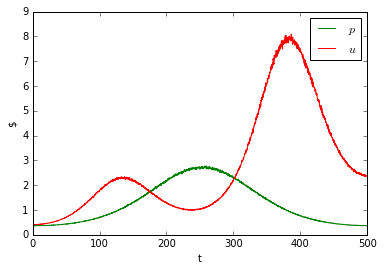

In [6]:
# Here we plot the demands u and prices p.
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(1)
numGen=30
numLoad=60
numCapacitor=30
T = 2000
t = np.linspace(1, T, num=T).reshape(T,1)
p = np.exp(-np.cos((t-15)*2*np.pi/T)+0.01*np.random.randn(T,1))
u = 2*np.exp(-np.random.uniform(0,1)*np.cos((t+np.random.uniform(35,40))*np.pi/T) - \
    np.random.uniform(0,1)*np.cos(t*4*np.pi/T)+0.01*np.random.randn(T,1))
p = np.asmatrix(p)
u = np.asmatrix(u)
plt.figure(1)
plt.plot(t/4, p, 'g', label=r"$p$");
plt.plot(t/4, u, 'r', label=r"$u$");
plt.ylabel("$")
plt.xlabel("t")
plt.legend()
plt.show()
u=u.T

In [19]:
# Solve for the minimum total cost. 

import cvxpy as cvx
Q = 35
C, D = 5, 5
A = 1
B = 2
g = cvx.Variable(numGen,T)
q = cvx.Variable(numCapacitor,T)
c = cvx.Variable(numCapacitor,T)
loss = 0
for i in xrange(numGen):
    loss=loss+cvx.sum_entries(A*(g[i,:])**2+B*(g[i,:]))
obj = cvx.Minimize(loss)
con = list()
con.append(cvx.sum_entries(g,axis=0)==numLoad*u+cvx.sum_entries(c,axis=0))
#con.append(cvx.sum_entries(g,axis=0)==numLoad*u)
#con.append(q[:,0]==q[:,T-1]+c[:,T-1])
for i in xrange(0,T-2):
    con.append(q[:,i+1]==q[:,i]+c[:,i])
for i in xrange(q.size[0]):
    con.append(q[i,:]<=Q+np.random.randn()*2)
    con.append(c[i,:]>=-D-np.random.randn()*2)
    con.append(c[i,:]<=C+np.random.randn()*2)
con.append(q>=0)
con.append(g>=0)
for i in xrange(numGen):
    con.append(g[i,:]<=16+np.random.randn()*2)
prob = cvx.Problem(obj,con)
prob.solve()
# TODO: your code here

inf

In [8]:
g.value.shape

(30, 2000)

In [11]:
import pickle
powerData={'generator':g.value,'load':u,'capacitor':q.value}
with open('powerData.pkl','w') as f:
    pickle.dump(powerData, f)

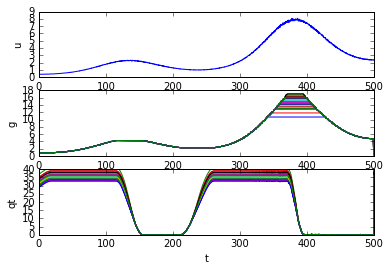

In [18]:
# Plot the optimal u and q against c and p.
plt.figure(2)
ts = np.linspace(1, T, num=T).reshape(T,1)/4
plt.subplot(3,1,1)
plt.plot(ts, u.T);
plt.xlabel('t')
plt.ylabel('u')

plt.subplot(3,1,2)
for i in xrange(numGen):
    plt.plot(ts, g.value[i,:].T);
plt.xlabel('t')
plt.ylabel('g')

plt.subplot(3,1,3)
for i in xrange(numCapacitor):
    plt.plot(ts, q.value[i,:].T);
plt.xlabel('t')
plt.ylabel('qt')
plt.ylim((0, 40))
plt.savefig('simulation.png')

## (c) Storage trade-offs

Plot the minimum total cost versus the storage capacity $Q$, using $p$ and
$u$ below, and charge/discharge limits $C = D = 3$. Repeat for
charge/discharge limits $C = D = 1$. (Put these two trade-off curves on the same plot.) Give
an interpretation of the endpoints of the trade-off curves.

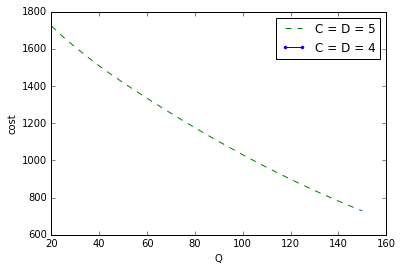

In [26]:
# Plot the tradeoff curves
N = 31
Qs = np.linspace(0, 150, num=N).reshape(N,1)
A = 1
B = 2
g = cvx.Variable(T)
q = cvx.Variable(T)
c = cvx.Variable(T)
Q = cvx.Parameter()

C, D = cvx.Parameter(), cvx.Parameter()
C.value = 1
D.value = 1
obj = cvx.Minimize(cvx.sum_entries(A*(g)**2+B*(g)))
con = list()
con.append(g==u+c)
con.append(q[0]==q[T-1]+c[T-1])
for j in xrange(0,T-2):
    con.append(q[j+1]==q[j]+c[j])
con.append(q<=Q)
con.append(q>=0)
con.append(c>=-D)
con.append(c<=C)
con.append(g>=0)
con.append(g<=5)
prob = cvx.Problem(obj,con)



cost1 = np.asmatrix(np.zeros((N,1)))

for i in range(N):
    Q.value = Qs[i]

    cost1[i] = prob.solve()
    
C.value = 3
D.value = 3
cost2 = np.asmatrix(np.zeros((N,1)))
for i in range(N):
    Q.value = Qs[i]
    cost2[i] = prob.solve()

plt.figure(3)
plt.plot(Qs, cost2, 'g--', label='C = D = 5');
plt.plot(Qs, cost1, 'b.-', label='C = D = 4');
plt.xlabel('Q')
plt.ylabel('cost')
plt.legend()
plt.show()